# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [47]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
import sklearn.feature_extraction
import sklearn.datasets

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [41]:
noise = .2

dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

noise2 = .4

dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise2))
dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise2)) #Please try this one
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise2))
dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise2))

In [11]:
#Bayes
clf1 = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf2 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf3 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf4 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf5 = sklearn.linear_model.LogisticRegression()

#Symbolists
clf6 = sklearn.tree.DecisionTreeClassifier()
clf7 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf8 = sklearn.neural_network.MLPClassifier()

#Ensemble
clf9 = sklearn.ensemble.GradientBoostingClassifier()
    
    

Now we fit the model by giving it our training data

In [8]:
def fit_model_df_evaluate(model, df_train, df_test):
    model.fit(np.stack(df_train['vect'], axis=0), df_train['category'])
    print(lucem_illud_2020.evaluateClassifier(model, df_test))
    #lucem_illud_2020.plotConfusionMatrix(model, df_test)
    #lucem_illud_2020.plotMultiROC(model, df_test)
    #lucem_illud_2020.plotregions(model, df_train)

In [9]:
def try_every_model(df_train, df_test):
    print("model 1")
    fit_model_df_evaluate(clf1, df_train, df_test)
    
    print("model 2")
    fit_model_df_evaluate(clf2, df_train, df_test)
    
    print("model 3")
    fit_model_df_evaluate(clf3, df_train, df_test)

    print("model 4")
    fit_model_df_evaluate(clf4, df_train, df_test)
    
    print("model 5")
    fit_model_df_evaluate(clf5, df_train, df_test)
   
    print("model 6")
    fit_model_df_evaluate(clf6, df_train, df_test)
    
    print("model 7")
    fit_model_df_evaluate(clf7, df_train, df_test)
    
    print("model 8")
    fit_model_df_evaluate(clf8, df_train, df_test)

    print("model 9")
    fit_model_df_evaluate(clf9, df_train, df_test)

## Exercise 1 Part 1:


df 1: Model 7 and 9 does best, but all have about a 50% accuarcy and recall. This makes sense, because the classifiers are assigned randomly, so the models also predict randomly, and thus have about a 50% accuracy. 

df 2: All models do very well, with the Random Forest ensemble doing the best. This also makes sense, because these classifiers are based on one feature, making it easy for any model to predict a classifier correctly.

df 3: In this case the gradient booster model does this best, with a high precision, recall and low error rate. This makes sense, because the classifier was assigned by splitting on both features. Therefore any simple linear separator would do poorly. The gradient booster uses multiple decision trees, so can separate classifiers by both features. This is why the prediction does best. 

df 4: In this case the naive bayes classifier does best, with random forests and neural nets closely following. In this case the classifer is not separated linearly, instead it is separated  

df 5: In this case all models do farily well, with precision and recall around 90%. In this case 5 categorical labels are assigned randomly in 5 groups, so a 50-50 chance means an error rate of about 10%, which is consist across models.
    
df 6: This is also split along one feature, but with double the noise than df 2. In this case all the models do okay, and have a similar AUC, precision and accuracy, but the ensemble Gradient Booster does slightly better than the rest.

df 7: In this case, the ensemble gradient booster does the best, with the random forest ensemble a close second. This is the same as with dataframe 3, which used the same splitting technique but with less noise. This classifier makes sense because the classifer is assigned based on two features, so the models that can take both into account to best.

df 8: Nueral networks do best here. This makes sense, because the classifications were assigned nested within two features. This makes it difficutlt for a machine to predict the labels with a linear model, so models that are non-linear do better. 

df 9: All the models did pretty well/equally well in this case. Again this makes sense because the labels were assigned randomly, so there is no way to predict the labels better than 50-50. This is the same as with dataframe 5. The increased noise doesn't impact the error rate.

df 10: This is the randomly assigned label across the whole dataframe. Increasing the noise on this dataframe doesn't change the dataframe, so the results are similar to dataframe 1, where all the models are pretty equal in predicting classifiers.


In [170]:
#try_every_model(dfTrain1, dfTest1)

In [171]:
#try_every_model(dfTrain2, dfTest2)

In [172]:
#try_every_model(dfTrain3, dfTest3)

In [173]:
#try_every_model(dfTrain4, dfTest4)

In [174]:
#try_every_model(dfTrain5, dfTest5)

In [175]:
#try_every_model(dfTrain6, dfTest6)

In [176]:
#try_every_model(dfTrain7, dfTest7)

In [177]:
#try_every_model(dfTrain8, dfTest8)

In [178]:
#try_every_model(dfTrain9, dfTest9)

## real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [6]:
dfTrain_red, dfTest_red = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
dfTrain_news, dfTest_news = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
dfTrain_sensm, dfTest_sensm = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
dfTrain_senl, dfTest_senl = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
dfTrain_spam, dfTest_spam = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Klobuchar
Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Kennedy
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


In [179]:
#try_every_model(dfTrain_red, dfTest_red)

### Redit Data

The support vector machine, logistic regression and nueral network all did fairly well for the reddit dataset. The SMV and logistic regression are linear classifiers, while neural network is not. This tells us that the labels were fairly easy to separate with a linear boundary, and difficult to pick just a few features that would be predictive of the classfier, which is why the decision trees and random forests did not do well. 

In [180]:
#try_every_model(dfTrain_news, dfTest_news)

### News Data
For the news data, the SVM model and the logistic regression again performed best, in terms of a low error rate and high AUC and precision. The nueral network also did well, but not as well. This points to the same conclusions as with the reddit dataset. 

In [181]:
#try_bevery_model(dfTrain_sensm, dfTest_sensm)

### Senate Small Data
In this case the Decision Tree classifier and Random Forest classifier are very accurate classifiers, with the random forest classifier doing best. Decision trees are less able to handle complicated rules that involve many features - this may mean that the few most important terms in the tf-idf matrix are very predictable of whether a speech is by Clinton or Obama. Random Forests do better because they are an ensemble of many decision trees. Additionally decision trees are better suited for smaller data, which makes sense in this case.

In [182]:
#try_every_model(dfTrain_senl, dfTest_senl)

### Senate Big

Neural Nets do best in this case, with almost perfect precision and recall. Nueral nets can adjust to complicated rules and work with large datasets, so this seems fitting. Decision trees are a close second, which is somewhat surprising. I would have to look more into the most predictive features in the decision tree to understand what exactly it is doing here. Interestly, the decision tree performs better than a random forest, suggesting that a random forest leads to some overfitting.

In [184]:
#try_every_model(dfTrain_spam, dfTest_spam)

### Spam Dataset

In this case decision trees and random forests work better. This seems consistent with above, that decision trees perform slightly better with smaller datasets and with fewer classes and a smaller dataset.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.

Note: Because my hand labeled dataset is too small, I am using a dataset from Kaggle. It contains 3000 tweets from hillary clinton and trump before the 2016 presidential election. 

### Summary of Results shown below:

The logistic regression with l1 penalty does slightly better than the naive bayes classifier on every score. As the confusion matrix shows, the logistic regression has more true positives and true negatives marginally than the naive bayes, and fewer false positives and false negatives. 

The accuracy for the logistic regression with L1 regularization does the better than any of the logistic regressions on the reduced dimension (PCA) matrix. The L1 regularization is also a way of reducing dimensions, it's a lasso regression that picks the most important features and reduces the rest to have a 0 coefficient. In this case the lasso does better than the PCA.

### Summary of Exercise 2 Analysis
(I ran this after doing the whole section)

In [129]:
lucem_illud_2020.evaluateClassifier(logistic_l1, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.127329,0.872375,0.883987,0.826522,0.853312
True,0.127329,0.872375,0.862426,0.823923,0.891437


In [130]:
lucem_illud_2020.evaluateClassifier(naiveBayes, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.13354,0.86621,0.875000,0.817646,0.850158
True,0.13354,0.86621,0.858631,0.817321,0.882263


### Full Exercise 2 Method

In [114]:
tweets = pandas.read_csv("tweets.csv")

In [72]:
tweets['category'] = [s == 'HillaryClinton' for s in tweets['handle']]

Tokenize and normalize

In [74]:
tweets['tokenized_text'] = tweets['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
tweets['normalized_text'] = tweets['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

split the data into training data and testing data.

In [76]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(tweets, holdBackFraction=holdBackFraction)

In [77]:
print(len(train_data_df))
print(len(test_data_df))

5156
1288


## Logistic Regression

Turn the training dataset into a tf-idf matrix

In [78]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

In [80]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

#### PCA

In [81]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [82]:
train_data_df['pca'] = [r for r in reduced_data]

In [85]:
len(train_data_df)

5156

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


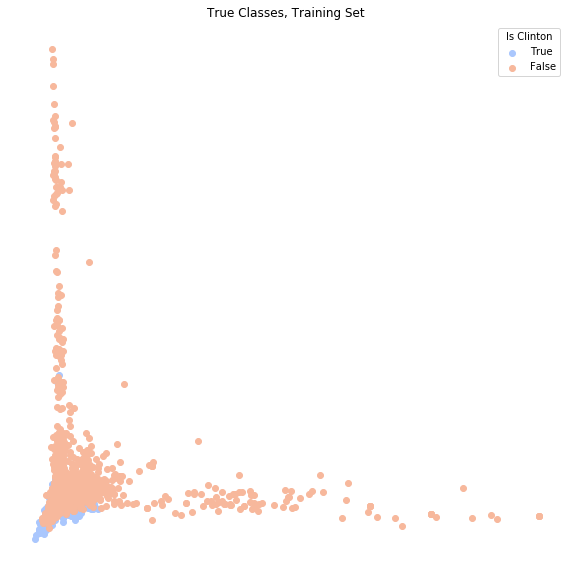

In [83]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Clinton
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Clinton
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Clinton')
plt.title('True Classes, Training Set')
plt.show()

choose the first 10 pricipal components as our covariates.

In [86]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [87]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [88]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.7668735453840186

Do on testing dataset

In [89]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.7593167701863354

In [90]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.806245151280062
Testing:
0.7942546583850931


Try with 100 features

In [91]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8281613653995346
Testing:
0.8136645962732919


Try with (200)

In [92]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8446470131885182
Testing:
0.8229813664596274


Use a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [94]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9354150504266874


Train the model using training data, and then test it on the testing data.

In [95]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8726708074534162


#### Other logistic measures

In [117]:
test_data_df['l1_predict'] = logistic_l1.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['l1_predict_prob_true'] = logistic_l1.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision

In [119]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['l1_predict'])

0.8624260355029586

Recall

In [120]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['l1_predict'])

0.8914373088685015

F1 Measure

In [121]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['l1_predict'])

0.8766917293233082

Confusion matrix

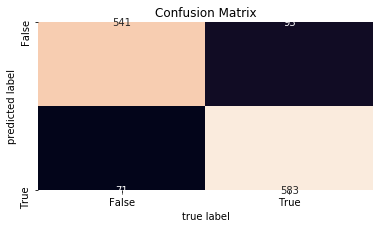

In [125]:
lucem_illud_2020.plotConfusionMatrix(logistic_l1, test_data_df)

In [128]:
lucem_illud_2020.evaluateClassifier(logistic_l1, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.127329,0.872375,0.883987,0.826522,0.853312
True,0.127329,0.872375,0.862426,0.823923,0.891437


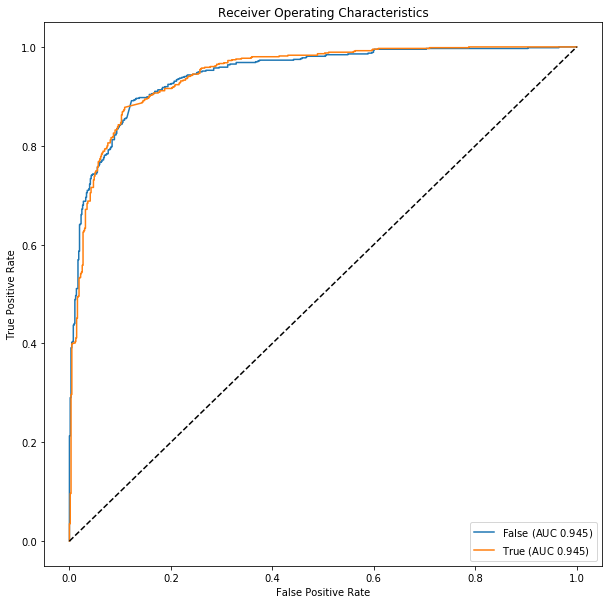

In [126]:
lucem_illud_2020.plotMultiROC(logistic_l1, test_data_df)

## Naive Bayes

In [96]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [97]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9272692009309542
Testing:
0.8664596273291926


In [98]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [99]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8586309523809523

Recall:

In [100]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.882262996941896

F1-measure:

In [101]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8702865761689291

Confusion Matrix

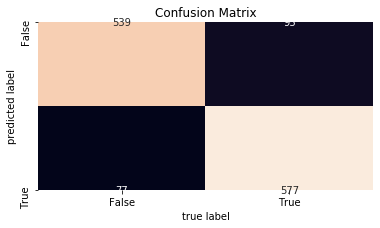

In [127]:
lucem_illud_2020.plotConfusionMatrix(naiveBayes, test_data_df)

Compare posterior distribution looks relative to the truth.

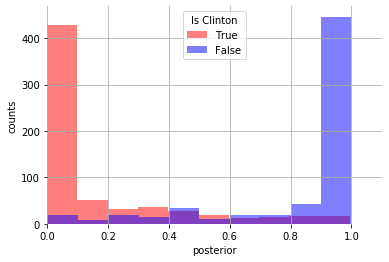

In [122]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Clinton")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

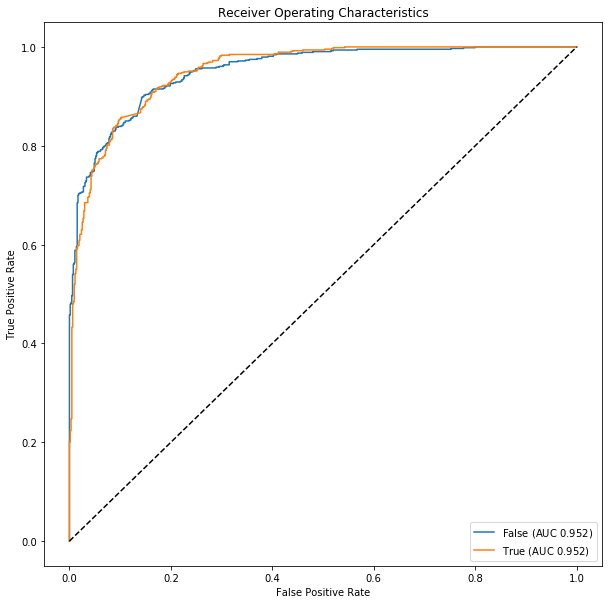

In [154]:
lucem_illud_2020.plotMultiROC(naiveBayes, test_data_df)

### Important words

In [116]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Trump' : [],
    'Trump_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Trump'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Trump_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Trump,Trump_log_prob,Clinton,Clinton_log_prob
0,cnn,-3.369231,ve,-3.387308
1,poll,-3.540379,hillaryclinton,-3.549151
2,bad,-3.553802,plan,-3.663562
3,enjoy,-3.553802,work,-3.678829
4,foxnews,-3.581201,know,-3.710082
5,media,-3.623761,tax,-3.758872
6,rubio,-3.623761,timkaine,-3.792773
7,amazing,-3.698984,live,-3.810165
8,tomorrow,-3.698984,right,-3.810165
9,win,-3.714733,got,-3.827865


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

I will use the tweets dataset above.

### Summary: 

Both decision trees and random forests performed quite poorly. Both models had particularly high false negatives, so the model labeled a Clinton tweet as a Trump tweet instead. This may be due to the use of handle names in each of their tweets. Decision trees effectively only pick the most important 10 features, so the ambigious use of handle tweets could result in poor classifiers. 

A random forest is essentially putting together many random shallow decision trees. With the vast amount of words used, a poor shallow decision trees in this case, using a randome forest doesn't result in a better classifier - which is reflected in the scores. Ensemble learning generally puts together various classifiers to enhance predicitions.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


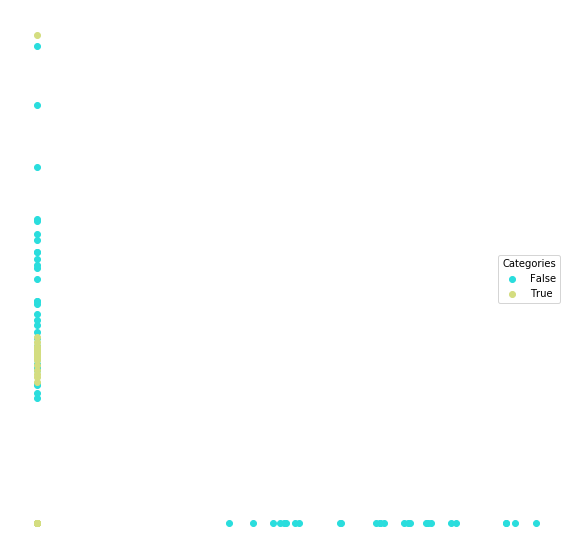

In [145]:
lucem_illud_2020.plotter(train_data_df)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [147]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=10,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


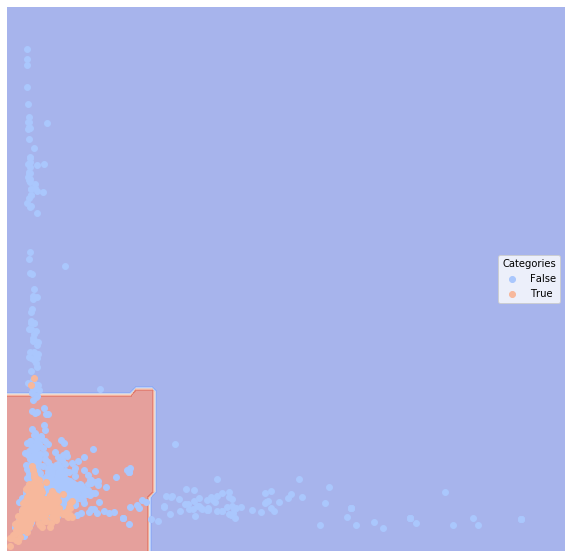

In [148]:
lucem_illud_2020.plotregions(clf_tree, train_data_df)

In [149]:
lucem_illud_2020.evaluateClassifier(clf_tree, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.390225,0.61067,0.979866,0.609353,0.226006
True,0.390225,0.61067,0.561404,0.561112,0.995334


Lets look at accuracy:

In [150]:
sklearn.metrics.accuracy_score(train_data_df['category'],clf_tree.predict(np.stack(train_data_df['vect'], axis = 0)))

0.6097750193948798

What happens if we trim the tree?

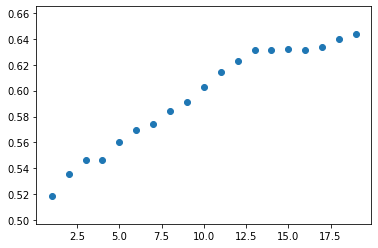

In [151]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

This chart suggests that a decision tree with about 10 branches will do well without overfitting the data. 

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [152]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [153]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
      

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


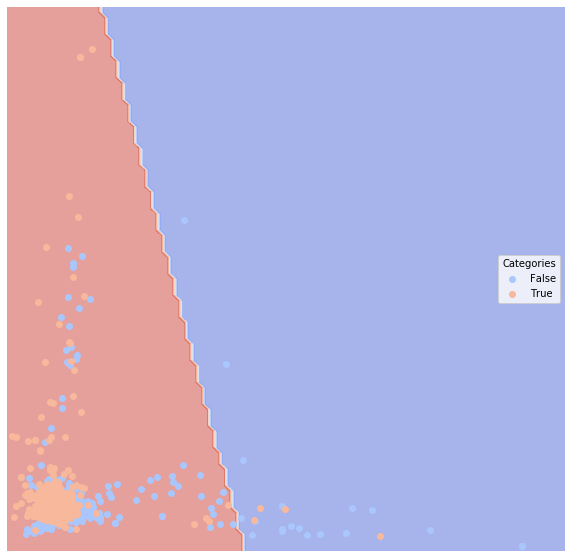

In [155]:
lucem_illud_2020.plotregions(bag, test_data_df)

In [156]:
lucem_illud_2020.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.350932,0.643774,0.950495,0.631015,0.302839
True,0.350932,0.643774,0.593002,0.591699,0.984709


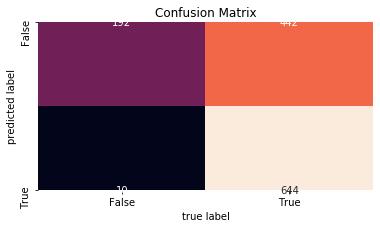

In [157]:
lucem_illud_2020.plotConfusionMatrix(bag, test_data_df)

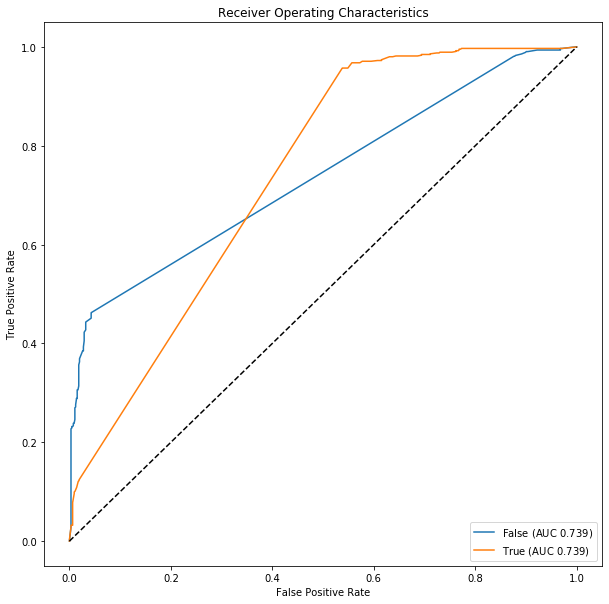

In [158]:
lucem_illud_2020.plotMultiROC(bag, test_data_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?



The k-nearest neighbors model acted strangely - it got zero true positives or false negatives. This results in 100% precision, but high errors and low accuracy. 

The K-nearest neighbor approach is a supervised learning algorithm, as opposed to k-means clustering. However both employ a measure of distance between points. K-means clustering creates k clusters of points that are close in mutli-dimensional space. The K-nearest neighbor approach plots labels points in multi-dimensional space and has the k observations closest to each observation determine it's label.

In [160]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [161]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_data_df['text'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [162]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [163]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.49069,0.508165,0.50528,0.50528,1.00000
True,0.49069,0.508165,1.00000,0.50702,0.01633


And lets look at the testing data

In [167]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['k_predict'] = clf_knearest.predict(np.stack(test_data_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.4984472049689441


Let's produce another confusion matrix:

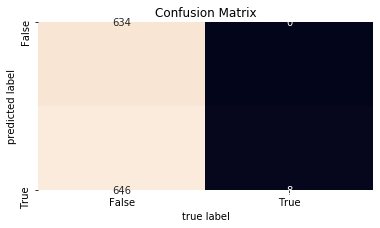

In [169]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_data_df)

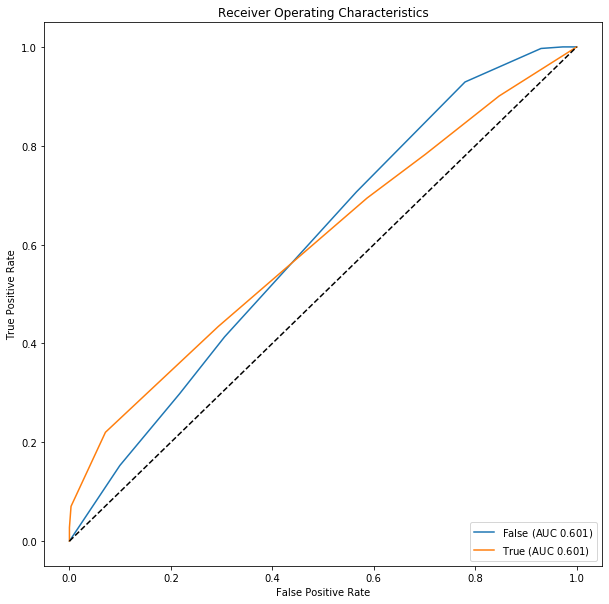

In [185]:
lucem_illud_2020.plotMultiROC(clf_knearest, test_data_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

# SVMs

These do much better the k-nearest neighbor with my data, but still not as good as l1 logistic regression models.

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [186]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

...and consider the results:

In [187]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.138975,0.860786,0.868720,0.810525,0.845426
True,0.138975,0.860786,0.853949,0.811073,0.876147


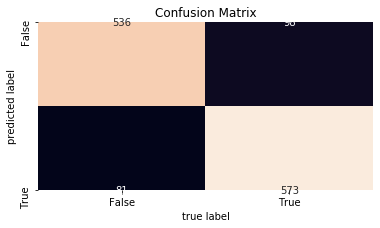

In [188]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


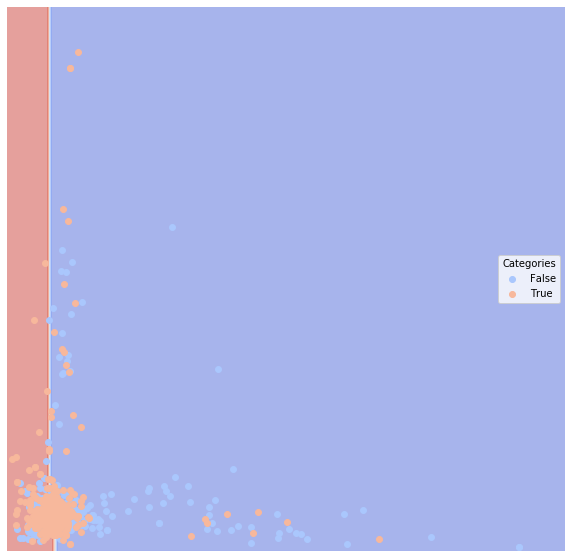

In [189]:
lucem_illud_2020.plotregions(clf_svm, test_data_df)

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">

In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to k-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?


Nueral Nets predict well, but the logistic regression with l1 regulatization, and naive bayes still perform slightly better on all metrics. This does perform decision-trees and k-nearest neighbors though.

In [191]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [192]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.149845,0.850565,0.828614,0.787230,0.876972
True,0.149845,0.850565,0.873582,0.809256,0.824159


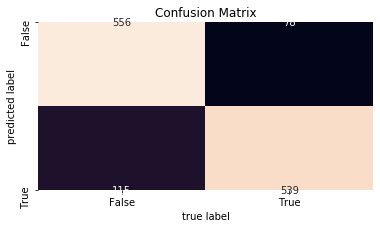

In [193]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


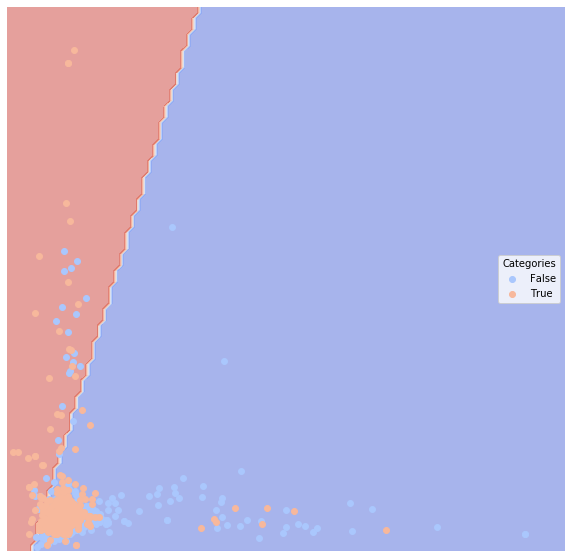

In [194]:
lucem_illud_2020.plotregions(clf_nn, test_data_df)

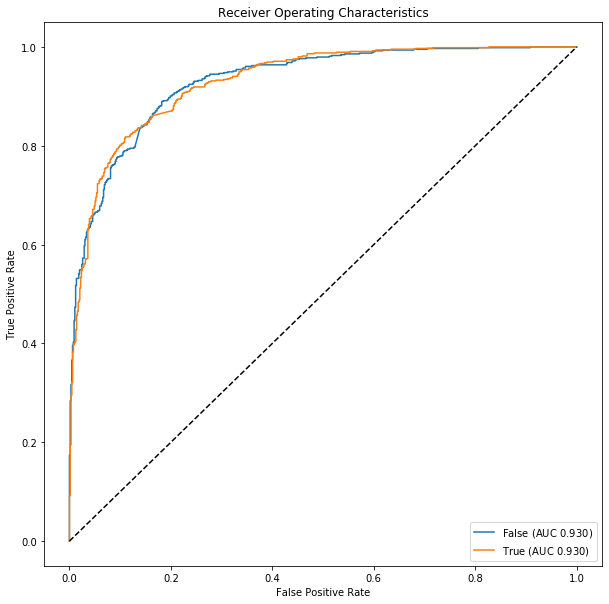

In [195]:
lucem_illud_2020.plotMultiROC(clf_nn, test_data_df)